# Sprawdzanie środowiska

In [107]:
from platform import python_version

print(python_version())

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

3.7.4


# Przygotowanie odpowiednich danych

In [108]:
'''
Dla PoC wykonuje obliczenia dla:
 * '../data/DogsCats'
Folder docelowy:
 * '../data/Photos'
'''

dir_path = '../../data/sCasia'
A_folder = 'originals'
B_folder = 'photoshops'

In [109]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

# Stałe

In [110]:
# Wilkości

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [111]:
'''
Opis danych:
1 - klasa 1 -> Originals
0 - klasa 2 -> Photoshops
''' 

A_folder_list = os.listdir(dir_path + '/' + A_folder)
B_folder_list = os.listdir(dir_path + '/' + B_folder)

filenames = []
categories = []

for filename in A_folder_list:
    categories.append(0)
    filenames.append(dir_path + '/' + A_folder + '/' + filename)

for filename in B_folder_list:
    categories.append(1)
    filenames.append(dir_path + '/' + B_folder + '/' + filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [112]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [113]:
df.head()

,filename,category
0,../../data/sCasia/originals/Au_ani_00096.jpg,0
1,../../data/sCasia/originals/Au_ani_00016.jpg,0
2,../../data/sCasia/originals/Au_ani_00031.jpg,0
3,../../data/sCasia/photoshops/Tp_D_CNN_S_N_sec0...,1
4,../../data/sCasia/photoshops/Tp_D_CNN_M_N_sec1...,1


In [114]:
df.shape

(200, 2)

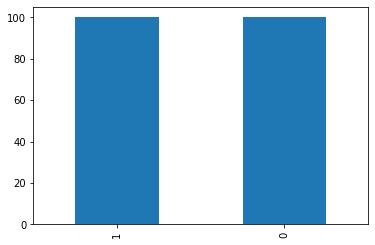

In [115]:
df['category'].value_counts().plot.bar()

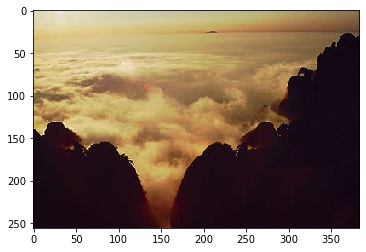

In [116]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)

# Obróbka zdjęć

In [133]:
from skimage.feature import hog
import mahotas
import cv2
from PIL import Image, ImageChops, ImageEnhance

def ft_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # chanels: [0,1,2], bo mamy przestrzeń HSV
    # mask: None
    # histSize: [8, 8, 8], bin count, po 8 dla każdego z kanałów
    # ranges : [0, 256, 0, 256, 0, 256], wszystko dla każdego z 3 kanałów
    hist  = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def ft_hog(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features, hog_image = hog(image, block_norm='L2-Hys', pixels_per_cell=(16, 16), visualize=True)
    return hog_features, hog_image


def ft_ela(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    im = Image.fromarray(image)
    im.save('tmp.jpg', 'JPEG', quality=90)
    resaved_im = Image.open('tmp.jpg')
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)

    return numpy.asarray(ela_im).flatten() / 255, ela_im
    

def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path)
        image = cv2.resize(image, IMAGE_SIZE)
        histogram = ft_histogram(image)
        ela = ft_ela(image)[0]
        hog = ft_hog(image)[0]
        global_feature = numpy.hstack([histogram, ela, hog])
        return global_feature
    except Exception as e:
        print(f'Problem with {image_path}, error_msg: {str(e)}')
    

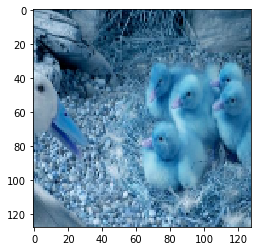

In [134]:
sample = random.choice(df['filename'])
image = cv2.imread(sample)
image = cv2.resize(image, IMAGE_SIZE)
plt.imshow(image)

In [135]:
sample

'../../data/sCasia/originals/Au_ani_00089.jpg'

Kształt: (49152,)
Min: 1.0
Max: 0.0


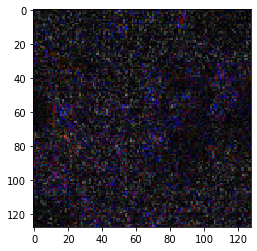

In [136]:
ela = ft_ela(image)

plt.imshow(ela[1])
print(f'Kształt: {ela[0].shape}')
print(f'Min: {numpy.amax(ela[0])}')
print(f'Max: {numpy.amin(ela[0])}')

Kształt: (2916,)
Min: 0.2124739490381904
Max: 0.010251874388283736


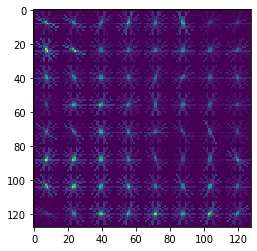

In [137]:
hog_img = ft_hog(image)

plt.imshow(hog_img[1])
print(f'Kształt: {hog_img[0].shape}')
print(f'Min: {numpy.amax(hog_img[0])}')
print(f'Max: {numpy.amin(hog_img[0])}')

In [138]:
histogram = ft_histogram(image)

print(f'Kształt: {histogram.shape}')
print(f'Min: {numpy.amax(histogram)}')
print(f'Max: {numpy.amin(histogram)}')

Kształt: (512,)
Min: 0.4431477189064026
Max: 0.0


# Przeliczenie Cech Zdjęć + Kategorii

In [139]:
g_f = []
l = []

for i in df['filename']:
    data_img = preprocess_image(i)
    g_f.append(data_img)

for i in df['category']:
    if i == 0:
        l.append('original')
    else:
        l.append('photoshop')

In [143]:
from sklearn.preprocessing import LabelEncoder

print(f'Wektor zdjęć: {numpy.array(g_f).shape}')
print(f'Wektor kategorii słownych: {numpy.array(l).shape}\n')

targetNames = numpy.unique(l)
le = LabelEncoder()
target = le.fit_transform(l)


print(f'Wektor kategorii liczbowych: {target.shape}')
print(f'Skalowany wektor zdjęć: {numpy.array(rescaled_features_gf).shape}\n')

print(f'Max arg z nieskalowanego: {numpy.argmax(g_f[0])}, Min arg z nieskalowanego: {numpy.argmin(g_f[0])}')
print(f'Max z nieskalowanego: {numpy.amax(g_f[0])}, Min z nieskalowanego: {numpy.amin(g_f[0])}\n')

Wektor zdjęć: (200, 52580)
Wektor kategorii słownych: (200,)

Wektor kategorii liczbowych: (200,)
Skalowany wektor zdjęć: (200, 52580)

Max arg z nieskalowanego: 25306, Min arg z nieskalowanego: 47
Max z nieskalowanego: 1.0, Min z nieskalowanego: 0.0



# Zapis/Odczyt

In [145]:
import h5py

def save(features, labels, dataframe, name):
    h5f_data = h5py.File('data_' + str(name) + '.h5', 'w')
    h5f_data.create_dataset('dataset', data=numpy.array(features))

    h5f_label = h5py.File('labels_' + str(name) + '.h5', 'w')
    h5f_label.create_dataset('dataset', data=numpy.array(labels))

    h5f_data.close()
    h5f_label.close()

    dataframe.to_csv('dataframe_' + str(name) + '.csv')
    
def load(features, labels, dataframe):
    h5f_data  = h5py.File(features, 'r')
    h5f_label = h5py.File(labels, 'r')

    global_features_string = h5f_data['dataset']
    global_labels_string   = h5f_label['dataset']

    global_features = numpy.array(global_features_string)
    global_labels   = numpy.array(global_labels_string)

    h5f_data.close()
    h5f_label.close()
    
    df = pd.read_csv(dataframe, index_col = 0)  
    
    return global_features, global_labels, df
    
save(g_f, target, df, name='Casia')

global_features, global_labels, df = load('data_Casia.h5', 'labels_Casia.h5', 'dataframe_Casia.csv')

In [146]:
df.head()

,filename,category
0,../../data/sCasia/originals/Au_ani_00096.jpg,0
1,../../data/sCasia/originals/Au_ani_00016.jpg,0
2,../../data/sCasia/originals/Au_ani_00031.jpg,0
3,../../data/sCasia/photoshops/Tp_D_CNN_S_N_sec0...,1
4,../../data/sCasia/photoshops/Tp_D_CNN_M_N_sec1...,1


In [151]:
print('Kształt po wczytaniu:')
print(f'\tglobal_features: {global_features.shape}')
print(f'\tglobal_labels: {global_labels.shape}')

Kształt po wczytaniu:
	global_features: (200, 52580)
	global_labels: (200,)


In [154]:
global_labels[0]

0

Kształt: (128, 128, 3)
Min: 255
Max: 0


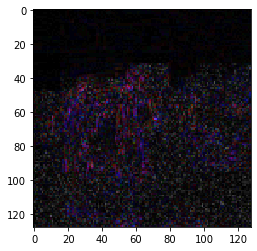

In [191]:
ela = global_features[0][512:49664] * 255
ela = ela.astype(numpy.uint8)
ela = ela.reshape(128, 128, 3)
ela.shape

print(f'Kształt: {ela.shape}')
print(f'Min: {numpy.amax(ela)}')
print(f'Max: {numpy.amin(ela)}')

plt.imshow(Image.fromarray(ela))

In [193]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
global_features_PCA = pca.fit_transform(global_features)

save(global_features_PCA, target, df, name='Casia_with_PCA')


global_features_PCA, global_labels_PCA, df_PCA = load('data_Casia_with_PCA.h5', 'labels_Casia_with_PCA.h5', 'dataframe_Casia_with_PCA.csv')

In [196]:
print(f'Bez PCA:')
print(f'\t Wektor zdjęć: {global_features.shape}')
print(f'\t Wektor kategorii słownych: {global_labels.shape}\n')
print(f'\t Wektor dataframe: {df.shape}\n\n')

print(f'Z PCA:')
print(f'\t Wektor zdjęć: {global_features_PCA.shape}')
print(f'\t Wektor kategorii słownych: {global_labels_PCA.shape}\n')
print(f'\t Wektor dataframe: {df_PCA.shape}')

Bez PCA:
	 Wektor zdjęć: (200, 52580)
	 Wektor kategorii słownych: (200,)

	 Wektor dataframe: (200, 2)


Z PCA:
	 Wektor zdjęć: (200, 100)
	 Wektor kategorii słownych: (200,)

	 Wektor dataframe: (200, 2)


In [198]:
df.head()

,filename,category
0,../../data/sCasia/originals/Au_ani_00096.jpg,0
1,../../data/sCasia/originals/Au_ani_00016.jpg,0
2,../../data/sCasia/originals/Au_ani_00031.jpg,0
3,../../data/sCasia/photoshops/Tp_D_CNN_S_N_sec0...,1
4,../../data/sCasia/photoshops/Tp_D_CNN_M_N_sec1...,1


In [199]:
df_PCA.head()

,filename,category
0,../../data/sCasia/originals/Au_ani_00096.jpg,0
1,../../data/sCasia/originals/Au_ani_00016.jpg,0
2,../../data/sCasia/originals/Au_ani_00031.jpg,0
3,../../data/sCasia/photoshops/Tp_D_CNN_S_N_sec0...,1
4,../../data/sCasia/photoshops/Tp_D_CNN_M_N_sec1...,1


# Funkcję liczące statystyki

In [200]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score

def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [201]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=True,
                          show_normed=True,
                          class_names=classes)

# Funkcje do liczenia modelu

In [202]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [203]:
from sklearn.svm import SVC
from sklearn import clone
import copy
from tabulate import tabulate
from scipy.stats import ttest_ind

def do_the_thing(features, labels):
    
    clf_list = {
        "SVM linear": [],
        "SVM poly": [],
        "SVM rbf": [],
        "SVM sigmoid": []
    }
    
    tcm_list = copy.deepcopy(clf_list)
    tAccuracy_list = copy.deepcopy(clf_list)
    tPrecision_list = copy.deepcopy(clf_list)
    tRecall_list = copy.deepcopy(clf_list)
    tFScore_list = copy.deepcopy(clf_list)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=odp)
    clfs = {
        "SVM linear": SVC(kernel='linear', probability=True, random_state=odp, verbose=True),
        "SVM poly": SVC(kernel='poly', probability=True, random_state=odp, verbose=True),
        "SVM rbf": SVC(kernel='rbf', probability=True, random_state=odp, verbose=True),
        "SVM sigmoid": SVC(kernel='sigmoid', probability=True, random_state=odp, verbose=True),
    }
    scores = numpy.zeros((len(clfs), 5))
    
    for fold_id, (train_index, test_index) in enumerate(kf.split(features, labels)):
        for clf_idx, clf_name in enumerate(clfs):
            clf = clone(clfs[clf_name])
            clf.fit(features[train_index], labels[train_index])
            y_pred = clf.predict(features[test_index])

            accuracy, precision, recall, fscore = countStats(labels[test_index], y_pred)
            cm = confusion_matrix(labels[test_index], y_pred)
            scores[clf_idx, fold_id] = accuracy_score(labels[test_index], y_pred)

            tAccuracy_list[clf_name].append(accuracy)
            tPrecision_list[clf_name].append(precision)
            tRecall_list[clf_name].append(recall)
            tFScore_list[clf_name].append(fscore)
            tcm_list[clf_name].append(cm)

    
    print(f'\n\nKształt danych:')
    print(f'\t X_train: {features[train_index].shape}')
    print(f'\t X_test: {features[test_index].shape}')
    print(f'\t y_train: {labels[train_index].shape}')
    print(f'\t y_test: {labels[test_index].shape}')
    
    results = []
    
    for elem in clf_list:
        accuracy_m = numpy.mean(tAccuracy_list[elem])
        precision_m = numpy.mean(tPrecision_list[elem])
        recall_m = numpy.mean(tRecall_list[elem])
        fscore_m = numpy.mean(tFScore_list[elem])
        
        accuracy_std = numpy.std(tAccuracy_list[elem])
        precision_std = numpy.std(tPrecision_list[elem])
        recall_std = numpy.std(tRecall_list[elem])
        fscore_std = numpy.std(tFScore_list[elem])
        
        cm = sum(tcm_list[elem])
        
        res = [str(elem), 
               f'{accuracy_m:.3f} ({accuracy_std:.2f})',
               f'{precision_m:.3f} ({precision_std:.2f})',
               f'{recall_m:.3f} ({recall_std:.2f})',
               f'{fscore_m:.3f} ({fscore_std:.2f})',
               f'{cm}']
        results.append(res)

    printmd(f'### Rezultaty:')
        
    headers = ["Kernel", "Accuracy", "Precision", "Recall", "Fscore", "CM"]
    print('\n')
    print(tabulate(results, headers=headers))
    
    
    printmd(f'### Analiza statystyczna:')
    
    alfa = .05
    t_statistic = numpy.zeros((len(clfs), len(clfs)))
    p_value = numpy.zeros((len(clfs), len(clfs)))

    for i in range(len(clfs)):
        for j in range(len(clfs)):
            t_statistic[i, j], p_value[i, j] = ttest_ind(scores[i], scores[j])
    headers = ["SVM linear", "SVM poly", "SVM rbf", "SVM sigmoid"]
    names_column = numpy.array([["SVM linear"], ["SVM poly"], ["SVM rbf"], ["SVM sigmoid"]])
    t_statistic_table = numpy.concatenate((names_column, t_statistic), axis=1)
    t_statistic_table = tabulate(t_statistic_table, headers, floatfmt=".2f")
    p_value_table = numpy.concatenate((names_column, p_value), axis=1)
    p_value_table = tabulate(p_value_table, headers, floatfmt=".2f")
    printmd("**t-statistic:**")
    print(t_statistic_table)
    printmd("**p-value:**")
    print(p_value_table)
    
    
    advantage = numpy.zeros((len(clfs), len(clfs)))
    advantage[t_statistic > 0] = 1
    advantage_table = tabulate(numpy.concatenate(
        (names_column, advantage), axis=1), headers)
    printmd("**Przewaga:**")
    print(advantage_table)
    
    
    significance = numpy.zeros((len(clfs), len(clfs)))
    significance[p_value <= alfa] = 1
    significance_table = tabulate(numpy.concatenate(
        (names_column, significance), axis=1), headers)
    printmd("**Różnice statystycznie znaczące (alpha = 0.05):**")
    print(significance_table)
    
    
    stat_better = significance * advantage
    stat_better_table = tabulate(numpy.concatenate(
        (names_column, stat_better), axis=1), headers)
    printmd("**Wynik końcowy analizy statystycznej:**")
    print(stat_better_table)

# Bez PCA

In [204]:
do_the_thing(global_features, global_labels)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Kształt danych:
	 X_train: (160, 52580)
	 X_test: (40, 52580)
	 y_train: (160,)
	 y_test: (40,)


### Rezultaty:



Kernel       Accuracy      Precision     Recall        Fscore        CM
-----------  ------------  ------------  ------------  ------------  ---------
SVM linear   0.705 (0.02)  0.708 (0.02)  0.705 (0.02)  0.704 (0.03)  [[70 30]
                                                                      [29 71]]
SVM poly     0.720 (0.04)  0.734 (0.05)  0.720 (0.04)  0.716 (0.04)  [[61 39]
                                                                      [17 83]]
SVM rbf      0.685 (0.02)  0.686 (0.02)  0.685 (0.02)  0.684 (0.02)  [[67 33]
                                                                      [30 70]]
SVM sigmoid  0.320 (0.06)  0.319 (0.06)  0.320 (0.06)  0.319 (0.06)  [[33 67]
                                                                      [69 31]]


### Analiza statystyczna:

**t-statistic:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear           0.00       -0.61       1.26          12.66
SVM poly             0.61        0.00       1.48          11.37
SVM rbf             -1.26       -1.48       0.00          12.34
SVM sigmoid        -12.66      -11.37     -12.34           0.00


**p-value:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear           1.00        0.56       0.24           0.00
SVM poly             0.56        1.00       0.18           0.00
SVM rbf              0.24        0.18       1.00           0.00
SVM sigmoid          0.00        0.00       0.00           1.00


**Przewaga:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           0          1              1
SVM poly                1           0          1              1
SVM rbf                 0           0          0              1
SVM sigmoid             0           0          0              0


**Różnice statystycznie znaczące (alpha = 0.05):**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           0          0              1
SVM poly                0           0          0              1
SVM rbf                 0           0          0              1
SVM sigmoid             1           1          1              0


**Wynik końcowy analizy statystycznej:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           0          0              1
SVM poly                0           0          0              1
SVM rbf                 0           0          0              1
SVM sigmoid             0           0          0              0


# Z PCA

In [205]:
do_the_thing(global_features_PCA, global_labels_PCA)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

d:\programs\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\programs\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Kształt danych:
	 X_train: (160, 100)
	 X_test: (40, 100)
	 y_train: (160,)
	 y_test: (40,)


### Rezultaty:



Kernel       Accuracy      Precision     Recall        Fscore        CM
-----------  ------------  ------------  ------------  ------------  ---------
SVM linear   0.555 (0.05)  0.559 (0.05)  0.555 (0.05)  0.551 (0.04)  [[50 50]
                                                                      [39 61]]
SVM poly     0.510 (0.01)  0.469 (0.20)  0.510 (0.01)  0.369 (0.03)  [[ 4 96]
                                                                      [ 2 98]]
SVM rbf      0.690 (0.02)  0.692 (0.02)  0.690 (0.02)  0.689 (0.02)  [[65 35]
                                                                      [27 73]]
SVM sigmoid  0.700 (0.04)  0.707 (0.04)  0.700 (0.04)  0.697 (0.04)  [[61 39]
                                                                      [21 79]]


### Analiza statystyczna:

**t-statistic:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear           0.00        1.90      -5.40          -4.67
SVM poly            -1.90        0.00     -15.35          -8.72
SVM rbf              5.40       15.35       0.00          -0.43
SVM sigmoid          4.67        8.72       0.43           0.00


**p-value:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear           1.00        0.09       0.00           0.00
SVM poly             0.09        1.00       0.00           0.00
SVM rbf              0.00        0.00       1.00           0.68
SVM sigmoid          0.00        0.00       0.68           1.00


**Przewaga:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           1          0              0
SVM poly                0           0          0              0
SVM rbf                 1           1          0              0
SVM sigmoid             1           1          1              0


**Różnice statystycznie znaczące (alpha = 0.05):**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           0          1              1
SVM poly                0           0          1              1
SVM rbf                 1           1          0              0
SVM sigmoid             1           1          0              0


**Wynik końcowy analizy statystycznej:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           0          0              0
SVM poly                0           0          0              0
SVM rbf                 1           1          0              0
SVM sigmoid             1           1          0              0
